<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap08/8_1_MNIST_1D_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 8.1: MNIST_1D_Performance**

This notebook runs a simple neural network on the MNIST1D dataset as in figure 8.2a. It uses code from https://github.com/greydanus/mnist1d to generate the data.

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [1]:
# Run this if you're in a Colab to install MNIST 1D repository
%pip install git+https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d to /private/var/folders/_1/lv4x6t2d7mx3wxjgz2q9kmp40000gn/T/pip-req-build-o7e8o6x1
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d /private/var/folders/_1/lv4x6t2d7mx3wxjgz2q9kmp40000gn/T/pip-req-build-o7e8o6x1
  Resolved https://github.com/greydanus/mnist1d to commit 68cb6b2d1d3a956cc2e9035e5a9860b66e33d642
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mnist1d: filename=mnist1d-0.0.2.post15-py3-none-any.whl size=14559 sha256=f16c0a371589aca8abc0f4330052632560178912de3cd894525e75ae3878cb02
  Stored in directory: /private/var/folders/_1/lv4x6t2d7mx3wxjgz2q9kmp40000gn/T/pip-ephem-wheel-cache-7l1repsz/wheels/d6/38/42/3d2112bc7d915f6195254ac85eb761d922d1b18f52817aa8e2
Successfully built mnist1d

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3.11 -m p

In [2]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d

Let's generate a training and test dataset using the MNIST1D code.  The dataset gets saved as a .pkl file so it doesn't have to be regenerated each time.

In [3]:
!mkdir ./sample_data

args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./sample_data/mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Did or could not load data from ./sample_data/mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [62]:
D_i = 40    # Input dimensions
D_k = 2000   # Hidden dimensions
D_o = 10    # Output dimensions

model = torch.nn.Sequential(
  torch.nn.Linear(D_i, D_k),
  torch.nn.ReLU(),
  torch.nn.Linear(D_k, D_k),
  torch.nn.ReLU(),
  torch.nn.Linear(D_k, D_k),
  torch.nn.ReLU(),
  torch.nn.Linear(D_k, D_o),
)

def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    torch.nn.init.kaiming_normal_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

# Call the function you just defined
model.apply(weights_init)


Sequential(
  (0): Linear(in_features=40, out_features=2000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2000, out_features=2000, bias=True)
  (3): ReLU()
  (4): Linear(in_features=2000, out_features=2000, bias=True)
  (5): ReLU()
  (6): Linear(in_features=2000, out_features=10, bias=True)
)

In [64]:
# choose cross entropy loss function (equation 5.24)
loss_function = torch.nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
# object that decreases learning rate by half every 10 epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('long'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('long'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 50
# store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_test = np.zeros((n_epoch))
errors_test = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, batch in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train)
  pred_test = model(x_test)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_test_class = torch.max(pred_test.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_test[epoch]= loss_function(pred_test, y_test).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler.step()

Epoch     0, train loss 1.636739, train error 67.07,  test loss 1.699083, test error 70.30
Epoch     1, train loss 1.300511, train error 48.78,  test loss 1.438170, test error 57.10
Epoch     2, train loss 1.039415, train error 39.17,  test loss 1.388538, test error 53.60
Epoch     3, train loss 0.844262, train error 30.05,  test loss 1.250776, test error 47.30
Epoch     4, train loss 0.540370, train error 18.80,  test loss 1.104344, test error 40.30
Epoch     5, train loss 0.384235, train error 12.40,  test loss 1.085424, test error 38.30
Epoch     6, train loss 0.287792, train error 9.30,  test loss 1.095732, test error 36.50
Epoch     7, train loss 0.200740, train error 6.50,  test loss 1.101410, test error 34.60
Epoch     8, train loss 0.115743, train error 3.10,  test loss 1.100233, test error 33.10
Epoch     9, train loss 0.065864, train error 1.53,  test loss 1.121988, test error 31.60
Epoch    10, train loss 0.016597, train error 0.03,  test loss 1.027445, test error 29.00
Epoc

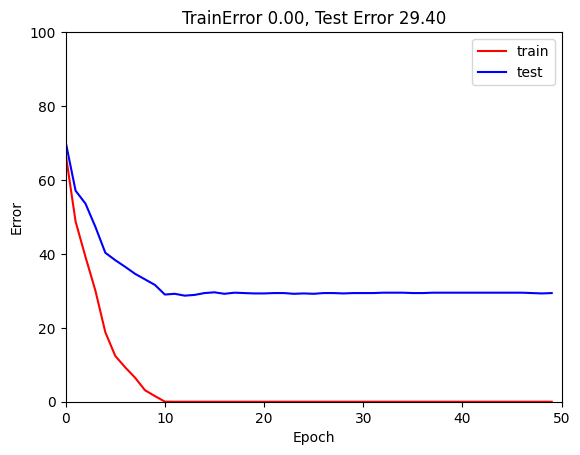

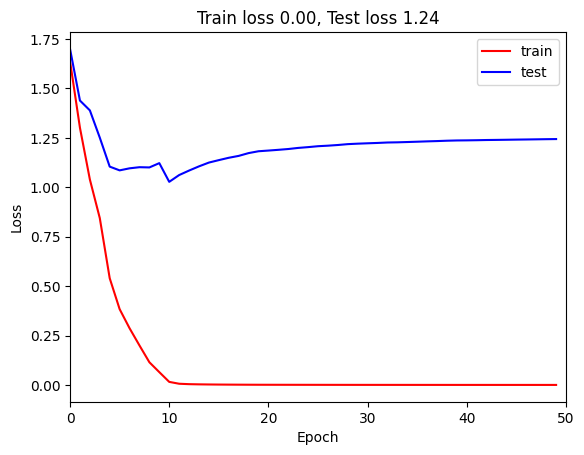

In [65]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_test,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train[-1],errors_test[-1]))
ax.legend()
plt.show()

# Plot the results
fig, ax = plt.subplots()
ax.plot(losses_train,'r-',label='train')
ax.plot(losses_test,'b-',label='test')
ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.set_title('Train loss %3.2f, Test loss %3.2f'%(losses_train[-1],losses_test[-1]))
ax.legend()
plt.show()

**TO DO**

Play with the model -- try changing the number of layers, hidden units, learning rate, batch size, momentum or anything else you like.  See if you can improve the test results.

Is it a good idea to optimize the hyperparameters in this way?  Will the final result be a good estimate of the true test performance?